The example below uses scikit-image library to detect circular features in farms using center pivot irrigation in Saudi Arabia. It then counts and reports the number of farms. This is one of the ways in which libraries from the scientific Python ecosystem can be integrated with the ArcGIS platform.

It uses the Multispectral Landsat imagery available at ArcGIS Online.

In [ ]:
from arcgis.gis import GIS
gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
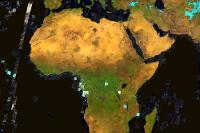

In [ ]:
l8 = gis.content.get('d9b466d6a9e647ce8d1dd5fe12eb434b')
l8lyr = l8.layers[0]
l8

The code below sets the extent of the layer, to a known extent of farms in Saudi Arabia and then visualizes the landsat layer:

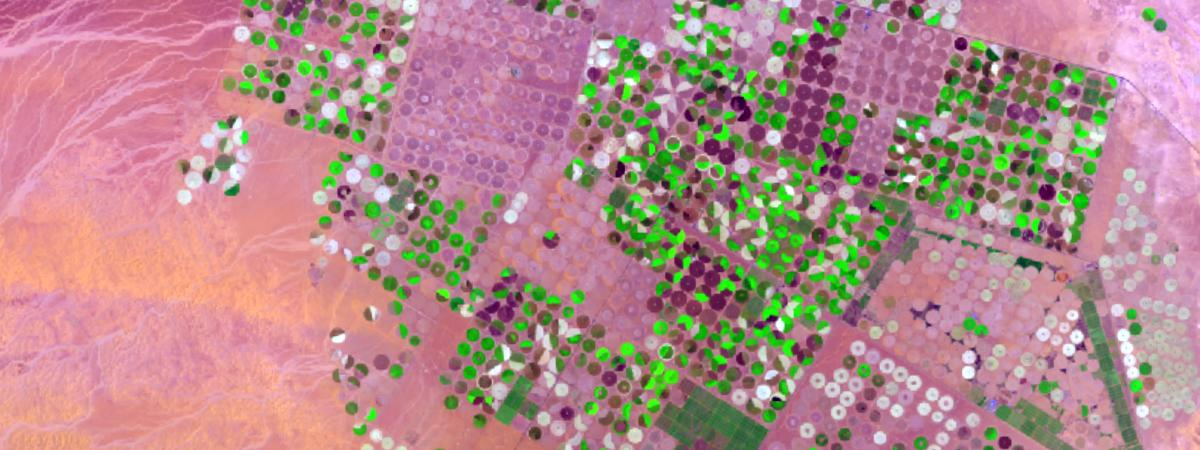

In [ ]:
l8lyr.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                                         'type': 'extent',
                                         'xmax': 4296559.143733407,
                                         'xmin': 4219969.241391764,
                                         'ymax': 3522726.823081019,
                                         'ymin': 3492152.0117669892}
l8lyr

We can preprocess the imagery using raster functions. The code below uses the ndvi raster function to identify areas that have healthy vegetation. This preprocessing step makes the scikit-image blob detection algorithm work better.

In [ ]:
from arcgis.raster.functions import ndvi, stretch

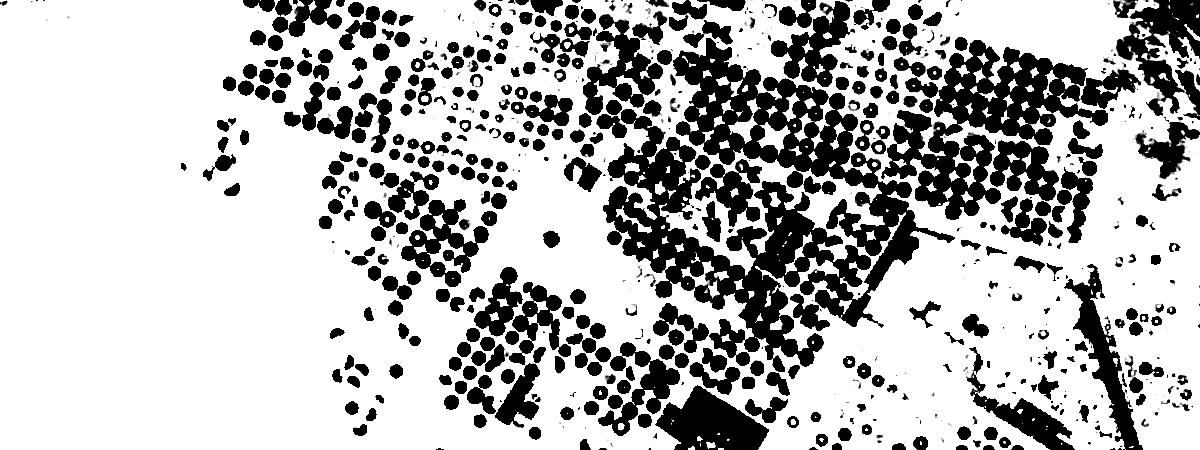

In [ ]:
stretch(ndvi(l8lyr), stretch_type='PercentClip', min_percent=30, max_percent=70, dra=True)

The code below exports the imagery to a file from which we read it using matplotlib's image API and plot it:

In [ ]:
img = stretch(ndvi(l8lyr), stretch_type='PercentClip', min_percent=30, max_percent=70, dra=True).export_image(bbox=l8lyr.extent, bbox_sr=102100, size=[1200, 450],
                       export_format='jpeg', save_folder='.', save_file='centerpivotfarms.jpg', f='image')

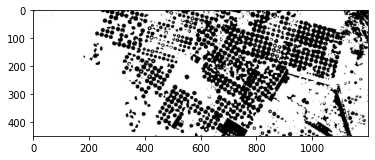

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('centerpivotfarms.jpg')

# what does it look like?
plt.imshow(img)
plt.show()

#**Blob detection using scikit-image**

The code below uses scikit-image library to find blobs in the given grayscale image, and reports the number of farms thus detected. It also plots them for visualization using matplotlib.

Blobs are found using the Difference of Gaussian (DoG) method.

/opt/conda/lib/python3.7/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/opt/conda/lib/python3.7/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/opt/conda/lib/python3.7/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/opt/conda/lib/python3.7/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


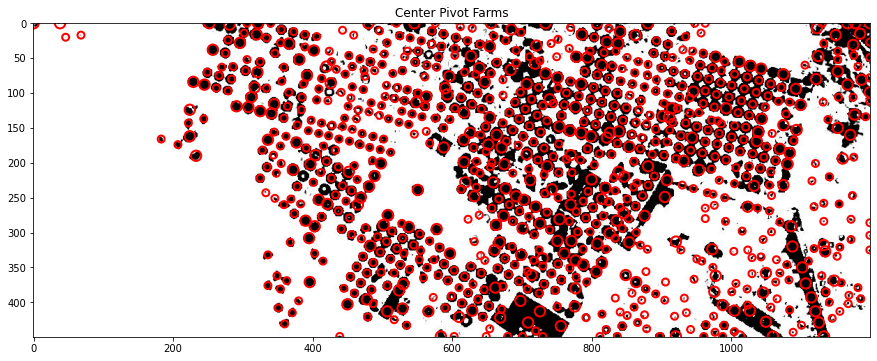

Number of center pivot farms detected: 886


In [ ]:
from skimage import feature, color
import matplotlib.pyplot as plt
bw = img.mean(axis=2)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)

blobs_dog = [(x[0],x[1],x[2]) for x in feature.blob_dog(-bw, 
                                                        min_sigma=4, 
                                                        max_sigma=8,
                                                        threshold=0.1,
                                                        overlap=0.6)]

#remove duplicates
blobs_dog = set(blobs_dog)

img_blobs = color.gray2rgb(img)

for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r+1, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.imshow(img_blobs)
plt.title('Center Pivot Farms')

plt.show()
print('Number of center pivot farms detected: ' + str(len(blobs_dog)))
